<a href="https://colab.research.google.com/github/juan-cv/Prediccion-Delictual/blob/main/modelo_xgboost_prediccion_reincidencia_delictual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicción reincidencia presos mediante algoritmo xgboost
# Invetigacion Privada Chile

Cada día es más frecuente la introducción de la ciencia de datos en el ámbito del derecho y la justicia.

Un ejemplo bien conocido de ello es el sistema COMPAS (Correctional offender management profiling for alternative sanctions) que se usa en varios estados de los Estados Unidos para hacer una evaluación del riesgo de reincidencia de las personas detenidas.

Una breve descripción del sistema puede verse en la página https://en.wikipedia.org/wiki/COMPAS_(software).

En este caso, proporciona un conjunto de datos en bruto con información de las evaluaciones (fichero compas-scores.csv) y la historia legal de unos 11 000 casos en los años 2013 y 2014 (se trata de uno de los ficheros originales utilizados en un análisis independiente del sistema COMPAS llevado a cabo por ProPublica, disponible en internet).

A partir de los datos del fichero vamos a intentar crear un modelo predictivo de la reincidencia de los presos tanto por delitos de tipo general como por delitos con violencia.


## 1. Carga de librerías

In [ ]:
# Cargamos librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier,plot_importance,plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')


## 2. Definición de funciones

In [ ]:
# Función para crear scatter-plots de las features 
def relaciones_vs_target(X, Y, return_type='axes'):
    fig_tot = (len(X.columns))
    fig_por_fila = 4
    tamanio_fig = 4
    num_filas = int( np.ceil(fig_tot/fig_por_fila) )    
    plt.figure( figsize=( fig_por_fila*tamanio_fig+5, num_filas*tamanio_fig+5 ) )
    c = 0 
    for i, col in enumerate(X.columns):
        plt.subplot(num_filas, fig_por_fila, i+1)
        sns.scatterplot(x=X[col], y=Y)
        plt.title( '%s vs %s' % (col, 'target') )
        plt.ylabel('Target')
        plt.xlabel(col)
    return

# Gráfico doble histográma
def represento_doble_hist(x_1, x_0, n_bins=11, title='', label_1='Clase 1', 
                          label_0='Clase 0'):
    bins = n_bins
    plt.hist(x_1, bins, alpha=0.5, label=label_1, color='red')    
    plt.hist(x_0, bins, alpha=0.5, label=label_0, color='green')
    plt.title(title)
    plt.legend(loc='best') 
    return

# Función para crear histogramas de las features para ambas clases a partir de la función anterior
def hist_pos_neg_feat(x, y, nbins=11, targets=(0,1)):
    fig_tot = len(x.columns)
    fig_tot_fila = 4; fig_tamanio = 4
    num_filas = int( np.ceil(fig_tot/fig_tot_fila) )
    plt.figure( figsize=( fig_tot_fila*fig_tamanio+2, num_filas*fig_tamanio+2 ) )
    target_neg, target_pos = targets
    for i, feat in enumerate(x.columns):
        plt.subplot(num_filas, fig_tot_fila, i+1);
        plt.title('%s' % feat)
        idx_pos = y == target_pos
        idx_neg= y == target_neg
        represento_doble_hist(x[feat][idx_pos].values, x[feat][idx_neg].values, nbins, title=('%s' % feat))
    return

# Graficar las matriz de confusión
def matriz_confusion(test,prediccion):
    cm=pd.DataFrame(confusion_matrix(test,prediccion))
    sns.heatmap(cm,annot=True,fmt="d",cmap="YlGnBu")
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Matriz de confusión')
    plt.show()
    return

## 3. Carga de datos

In [ ]:
# Cargamos los datos 
df=pd.read_csv('../input/compas-scores/compas-scores.csv',sep=',',\
                       parse_dates=['compas_screening_date','dob','c_jail_in','c_jail_out','c_offense_date','c_arrest_date',\
                                    'r_offense_date','r_jail_in','r_jail_out','vr_offense_date','v_screening_date',\
                                    'screening_date'])
# Visualizamos las primeras filas
df.head(3)

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,vr_offense_date,vr_charge_desc,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,type_of_assessment,decile_score.1,score_text,screening_date
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,NaT,NaN,Risk of Violence,1,Low,2013-08-14,Risk of Recidivism,1,Low,2013-08-14
1,2,michael ryan,michael,ryan,2014-12-31,Male,1985-02-06,31,25 - 45,Caucasian,...,NaT,NaN,Risk of Violence,2,Low,2014-12-31,Risk of Recidivism,5,Medium,2014-12-31
2,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,2013-07-05,Felony Battery (Dom Strang),Risk of Violence,1,Low,2013-01-27,Risk of Recidivism,3,Low,2013-01-27


In [ ]:
# Nos quedamos con las features de interés para el modelo
lista_variables=['sex','age','race','juv_fel_count','priors_count','juv_misd_count','decile_score','v_decile_score',
                 'is_recid','is_violent_recid','compas_screening_date','r_offense_date','vr_offense_date']
compas=df[lista_variables]

Aclaremos el significado de algunas de las variables menos obvias:
* **juv_fel_count**: número de delitos de joven.
* **juv_misd_count**: número de delitos menores de joven.
* **priors_count**: número de crímenes cometidos previamente.
* **decile_score**: decil de la puntuación del modelo Compas para reincidencia por delitos de tipo general.
* **v_decile_score**: decil de la puntuación del modelo Compas para reincidencia por delitos con violencia.
* **is_recid**: si el preso reincide o no por delitos de tipo general.
* **is_violent_recid**: si el preso reincide o no por delitos con violencia.
* **compas_screening_date**: fecha de valoración con el modelo Compas.
* **r_offense_date**: fecha de reincidencia por delitos de tipo general.
* **vr_offense_date**: fecha de reincidencia por delitos con violencia.



## 4. Preprocesamiento de datos

In [ ]:
# Resumen de los datos
compas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11757 entries, 0 to 11756
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   sex                    11757 non-null  object        
 1   age                    11757 non-null  int64         
 2   race                   11757 non-null  object        
 3   juv_fel_count          11757 non-null  int64         
 4   priors_count           11757 non-null  int64         
 5   juv_misd_count         11757 non-null  int64         
 6   decile_score           11757 non-null  int64         
 7   v_decile_score         11757 non-null  int64         
 8   is_recid               11757 non-null  int64         
 9   is_violent_recid       11757 non-null  int64         
 10  compas_screening_date  11757 non-null  datetime64[ns]
 11  r_offense_date         3703 non-null   datetime64[ns]
 12  vr_offense_date        882 non-null    datetime64[ns]
dtypes

In [ ]:
# Análisis estadístico preeliminar de los datos
compas.describe(include="all")

,sex,age,race,juv_fel_count,priors_count,juv_misd_count,decile_score,v_decile_score,is_recid,is_violent_recid,compas_screening_date,r_offense_date,vr_offense_date
count,11757,11757.000000,11757,11757.000000,11757.000000,11757.000000,11757.000000,11757.000000,11757.000000,11757.000000,11757,3703,882
unique,2,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,704,1090,599
top,Male,NaN,African-American,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-03-20 00:00:00,2014-12-08 00:00:00,2015-08-15 00:00:00
freq,9336,NaN,5813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39,12,6
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-01-01 00:00:00,2013-01-03 00:00:00,2013-01-28 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-31 00:00:00,2016-03-29 00:00:00,2016-03-13 00:00:00
mean,NaN,35.143319,NaN,0.061580,3.082164,0.076040,4.371268,3.571489,0.253806,0.075019,NaN,NaN,NaN
std,NaN,12.022894,NaN,0.445328,4.687410,0.449757,2.877598,2.500479,0.558324,0.263433,NaN,NaN,NaN
min,NaN,18.000000,NaN,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,NaN,NaN,NaN
25%,NaN,25.000000,NaN,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,NaN,NaN,NaN


* Existen valores **nulos** en 2 columnas **"r_offense_date" y vr_offense_date"**. 
* Tenemos variables tipo objeto **"sex" y "race"** que debemos **convertir en numéricas** para su introducción en algoritmos de machine learning.
* Vemos valores **negativos en "decile_score"	y "v_decile_score"** que son las puntuaciones del modelo compas lo que no tiene sentido. Lo mismo suede con "is_recid" que solo debería tener los valores cero y uno. Veremos como corregirlo.

### 4.1. Valores nulos

In [ ]:
# Resumen de nulos
compas.isnull().sum()

sex                          0
age                          0
race                         0
juv_fel_count                0
priors_count                 0
juv_misd_count               0
decile_score                 0
v_decile_score               0
is_recid                     0
is_violent_recid             0
compas_screening_date        0
r_offense_date            8054
vr_offense_date          10875
dtype: int64

In [ ]:
# Visualizamos los registros con nulos
compas[compas.r_offense_date.isnull() | compas.vr_offense_date.isnull()].head()

,sex,age,race,juv_fel_count,priors_count,juv_misd_count,decile_score,v_decile_score,is_recid,is_violent_recid,compas_screening_date,r_offense_date,vr_offense_date
0,Male,69,Other,0,0,0,1,1,0,0,2013-08-14,NaT,NaT
1,Male,31,Caucasian,0,0,0,5,2,-1,0,2014-12-31,NaT,NaT
3,Male,24,African-American,0,4,0,4,3,1,0,2013-04-14,2013-06-16,NaT
4,Male,23,African-American,0,1,1,8,6,0,0,2013-01-13,NaT,NaT
5,Male,43,Other,0,2,0,1,1,0,0,2013-03-26,NaT,NaT


Vemos que estas variables se corresponden con fechas que solo tienen valores no nulos si el preso fue reincidente como es lógico. Por tanto no tenemos que realizar ningún tratamiento de estos casos.

### 4.2. Valores negativos

In [ ]:
# Recuento de casos negativos de decile_score
compas.decile_score[compas.decile_score<0].count()

15

In [ ]:
# Visualizamos esos valores
compas[compas.decile_score<0].head()

,sex,age,race,juv_fel_count,priors_count,juv_misd_count,decile_score,v_decile_score,is_recid,is_violent_recid,compas_screening_date,r_offense_date,vr_offense_date
28,Male,24,African-American,0,2,0,-1,6,1,0,2014-10-16,2015-01-12,NaT
528,Female,60,Caucasian,0,0,0,-1,-1,-1,0,2013-11-25,NaT,NaT
758,Male,27,Caucasian,0,1,0,-1,-1,0,0,2013-05-13,NaT,NaT
901,Male,48,Caucasian,0,3,0,-1,3,1,0,2013-04-11,2014-03-14,NaT
3027,Female,53,Caucasian,0,0,0,-1,-1,0,0,2013-05-07,NaT,NaT


Vamos a suponer que se introdujo -1 en lugar de 1 por error

In [ ]:
# Cambiamos -1 por 1 en decile_score
compas.decile_score[compas.decile_score==-1]=1

In [ ]:
# Recuento de casos negativos de v_decile_score
compas.v_decile_score[compas.v_decile_score<0].count()

5

In [ ]:
# Visualizamos esos valores
compas[compas.v_decile_score<0].head()

,sex,age,race,juv_fel_count,priors_count,juv_misd_count,decile_score,v_decile_score,is_recid,is_violent_recid,compas_screening_date,r_offense_date,vr_offense_date
528,Female,60,Caucasian,0,0,0,1,-1,-1,0,2013-11-25,NaT,NaT
758,Male,27,Caucasian,0,1,0,1,-1,0,0,2013-05-13,NaT,NaT
3027,Female,53,Caucasian,0,0,0,1,-1,0,0,2013-05-07,NaT,NaT
8166,Male,25,African-American,0,1,0,1,-1,0,0,2013-03-12,NaT,NaT
10631,Male,60,African-American,0,1,0,1,-1,0,0,2013-04-03,NaT,NaT


In [ ]:
# Tambien corregimos los valores de -1 a 1
compas.v_decile_score[compas.v_decile_score==-1]=1

In [ ]:
# Recuento de casos negativos de is_recid
compas.is_recid[compas.is_recid<0].count()

719

In [ ]:
# Visualizamos esos valores
compas[compas.is_recid<0].head()

,sex,age,race,juv_fel_count,priors_count,juv_misd_count,decile_score,v_decile_score,is_recid,is_violent_recid,compas_screening_date,r_offense_date,vr_offense_date
1,Male,31,Caucasian,0,0,0,5,2,-1,0,2014-12-31,NaT,NaT
35,Female,49,Caucasian,0,0,0,1,1,-1,0,2013-03-04,NaT,NaT
45,Male,29,Caucasian,0,0,0,8,6,-1,0,2013-02-26,NaT,NaT
57,Male,36,African-American,0,0,0,1,1,-1,0,2013-04-15,NaT,NaT
108,Male,41,African-American,0,0,0,2,1,-1,0,2014-08-14,NaT,NaT


In [ ]:
# Visualizamos esos valores en el dataframe original
df[df.is_recid<0][['is_recid','r_charge_desc','r_offense_date']].head()

,is_recid,r_charge_desc,r_offense_date
1,-1,NaN,NaT
35,-1,NaN,NaT
45,-1,NaN,NaT
57,-1,NaN,NaT
108,-1,NaN,NaT


Vemos que en estos registros no hay ni cargo ni fecha de reincidencia. Por tanto podemos suponer que es un error y que en lugar de -1 son 0 (no reincidentes).

In [ ]:
# Corregimos los valores de -1 a 1
compas.is_recid[compas.is_recid==-1]=1

In [ ]:
# Comprobamos que ya no quedan negativos
compas.describe()

,age,juv_fel_count,priors_count,juv_misd_count,decile_score,v_decile_score,is_recid,is_violent_recid
count,11757.000000,11757.000000,11757.000000,11757.000000,11757.000000,11757.000000,11757.000000,11757.000000
mean,35.143319,0.061580,3.082164,0.076040,4.373820,3.572340,0.376116,0.075019
std,12.022894,0.445328,4.687410,0.449757,2.873718,2.499264,0.484430,0.263433
min,18.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,25.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000
50%,32.000000,0.000000,1.000000,0.000000,4.000000,3.000000,0.000000,0.000000
75%,43.000000,0.000000,4.000000,0.000000,7.000000,5.000000,1.000000,0.000000
max,96.000000,20.000000,43.000000,13.000000,10.000000,10.000000,1.000000,1.000000


### 4.3. Tipo de variables

In [ ]:
compas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11757 entries, 0 to 11756
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   sex                    11757 non-null  object        
 1   age                    11757 non-null  int64         
 2   race                   11757 non-null  object        
 3   juv_fel_count          11757 non-null  int64         
 4   priors_count           11757 non-null  int64         
 5   juv_misd_count         11757 non-null  int64         
 6   decile_score           11757 non-null  int64         
 7   v_decile_score         11757 non-null  int64         
 8   is_recid               11757 non-null  int64         
 9   is_violent_recid       11757 non-null  int64         
 10  compas_screening_date  11757 non-null  datetime64[ns]
 11  r_offense_date         3703 non-null   datetime64[ns]
 12  vr_offense_date        882 non-null    datetime64[ns]
dtypes

Hay que convertir "sex" y "race" en numéricas para su introducción en algunos de los algoritmos.

In [ ]:
# Valores de "sex"
compas.sex.value_counts()

Male      9336
Female    2421
Name: sex, dtype: int64

Se trata de una variable objeto que tiene 2 categorias

In [ ]:
# Reemplazamos categorías por 0-1
compas.sex.replace({"Male":1,"Female":0},inplace=True)

# Conversión en numérica
compas.sex=compas.sex.astype('int')

In [ ]:
# Valores de "race"
compas.race.value_counts()

African-American    5813
Caucasian           4085
Hispanic            1100
Other                661
Asian                 58
Native American       40
Name: race, dtype: int64

In [ ]:
# Convertimos las categorías de "race" en variables dummies
compas=pd.get_dummies(data=compas,columns=['race'],dtype='int')

### 4.4. Creación de features

Según informa la empresa fuente de los datos (ProPúplica) en su informe metodológico: "para la mayor parte de nuestro análisis, definimos la reincidencia como un nuevo arresto dentro de dos años. Basamos esta decisión en la guía para profesionales de Northpointe, que dice que su puntaje de reincidencia está destinado a predecir" un nuevo delito menor o delito mayor dentro de los dos años de la COMPAS fecha de administración."

Por tanto, en ambos campos, no deberían ser considerados los casos con valores iguales a 1 (personas reeincidentes en la realidad) en los que el tiempo pasado desde la evaluación COMPAS hasta la fecha de reincidencia fuera mayor de 2 años. No sería correcto introducir estos casos a la hora de evaluar la precisión de las estimaciones de riesgo generadas por COMPAS, ya que se considerarían como reincidentes casos que no fueron contemplados en la definición del modelo creado por Northpointe.

Ante esto vamos a crear 2 nuevas features, una para cada tipo de reincidencia (general/violenta) en la que se computen como reincidentes (valor 1) solo los casos en los que el tiempo entre fechas sea menor o igual a 2 años. El resto será no reincidente.

In [ ]:
# Creamos 2 nuevas features a partir de la diferencia entre las fechas de reincidencia y la de evaluación COMPAS (en años):
compas['tiempo_reincidencia_g']=(compas['r_offense_date']-compas['compas_screening_date']).dt.days / 365
compas['tiempo_reincidencia_v']=(compas['vr_offense_date']-compas['compas_screening_date']).dt.days / 365

In [ ]:
# Comprobamos el número de casos que no cumplen el criterio de reincidencia general
len(compas[(compas.is_recid==1) & (compas.tiempo_reincidencia_g > 2)])

278

In [ ]:
# Comprobamos el número de casos que no cumplen el criterio de reincidencia con violencia
len(compas[(compas.is_violent_recid==1) & (compas.tiempo_reincidencia_v > 2)])

113

Efectivamente hay 278 casos de nuevos arrestos por motivos generales y 113 por violentos tras más de 2 años desde la fecha de evaluación COMPAS y por tanto el valor de reincidencia debería ser 0 y no 1. Creamos 2 nuevas variables que serán las targets que informen si el preso ha sido o no reincidente en los 2 años después del screening según el modelo Compas.

In [ ]:
# Creación variables 
compas['reincidente_g']=np.where(((compas.is_recid==1) & (compas.tiempo_reincidencia_g<=2)),1,0)
compas['reincidente_v']=np.where(((compas.is_violent_recid==1) & (compas.tiempo_reincidencia_v<=2)),1,0)

De cara al modelo de machine learning no nos van a hacer falta algunas de las variables originales y las podemos eliminar:
* is_recid (en su lugar usamos "reincidente_g")
* is_violent_recid (en su lugar usamos "reincidente_v")
* compas_screening_date
* r_offense_date
* vr_offense_date
* race_Other (Eliminamos una de las dummies de raza para evitar problemas de colinealidad en el modelo)
* tiempo_reincidencia_g
* tiempo_reincidencia_v

In [ ]:
lista_eliminar=['is_recid','is_violent_recid',
                'compas_screening_date','r_offense_date','vr_offense_date',
                'race_Other','tiempo_reincidencia_g','tiempo_reincidencia_v']
compas.drop(lista_eliminar,axis=1,inplace=True)

In [ ]:
compas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11757 entries, 0 to 11756
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   sex                    11757 non-null  int64
 1   age                    11757 non-null  int64
 2   juv_fel_count          11757 non-null  int64
 3   priors_count           11757 non-null  int64
 4   juv_misd_count         11757 non-null  int64
 5   decile_score           11757 non-null  int64
 6   v_decile_score         11757 non-null  int64
 7   race_African-American  11757 non-null  int64
 8   race_Asian             11757 non-null  int64
 9   race_Caucasian         11757 non-null  int64
 10  race_Hispanic          11757 non-null  int64
 11  race_Native American   11757 non-null  int64
 12  reincidente_g          11757 non-null  int64
 13  reincidente_v          11757 non-null  int64
dtypes: int64(14)
memory usage: 1.3 MB


## 5. División en features X + targets Y

In [ ]:
# División los datos en features y targets

# Predicción delitos de tipo general
X_g=compas.drop(['reincidente_g','reincidente_v'],axis=1)
Y_g=compas['reincidente_g']

# Predicción delitos con violencia
X_v=compas.drop(['reincidente_g','reincidente_v'],axis=1)
Y_v=compas['reincidente_v']

## 6. Visualización y correlaciones

### 6.1. Descriptivos básicos

In [ ]:
compas.describe()

,sex,age,juv_fel_count,priors_count,juv_misd_count,decile_score,v_decile_score,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,reincidente_g,reincidente_v
count,11757.000000,11757.000000,11757.000000,11757.000000,11757.000000,11757.000000,11757.000000,11757.000000,11757.000000,11757.000000,11757.000000,11757.000000,11757.000000,11757.000000
mean,0.794080,35.143319,0.061580,3.082164,0.076040,4.373820,3.572340,0.494429,0.004933,0.347453,0.093561,0.003402,0.291316,0.065408
std,0.404389,12.022894,0.445328,4.687410,0.449757,2.873718,2.499264,0.499990,0.070066,0.476181,0.291230,0.058232,0.454388,0.247255
min,0.000000,18.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,25.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,32.000000,0.000000,1.000000,0.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,43.000000,0.000000,4.000000,0.000000,7.000000,5.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,96.000000,20.000000,43.000000,13.000000,10.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


En las variables no dicotómicas "juv_fel_count", "priors_count" y "juv_misd_count" vemos que la mayor parte de los casos son cero y por tanto los pocos casos distintos de cero pueden parecer outliers, pero no los trataremos porque es posible que ofrezcan información para predecir algunos casos, ya que parece razonable pensar que la delincuencia juvenil o el historial delictivo previo puedan tener relación con una mayor tendencia a reincidir. 

### 6.2. Diagramas de caja y bigotes (boxplots)

In [ ]:
# Bosxplots de las variables continuas
# Normalizamos para tener rangos comparables en las features no dicotómicas
variables_boxplot=['age','juv_fel_count','priors_count','juv_misd_count','decile_score','v_decile_score']
compas_boxplot=compas[variables_boxplot]
compas_norm=(compas_boxplot-compas_boxplot.mean())/compas_boxplot.std()

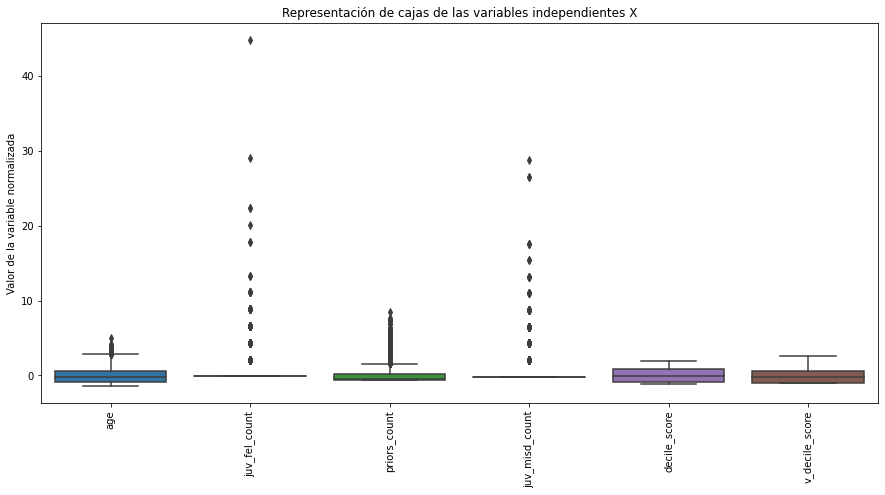

In [ ]:
# Bosxplots de las variables continuas

# Selección de las variables a mostrar
variables_boxplot=['age','juv_fel_count','priors_count','juv_misd_count','decile_score','v_decile_score']
compas_boxplot=compas[variables_boxplot]

# Normalizamos para tener rangos comparables
compas_norm=(compas_boxplot-compas_boxplot.mean())/compas_boxplot.std()

# Graficamos
plt.figure(figsize=(15,7))
ax = sns.boxplot(data=compas_norm)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Representación de cajas de las variables independientes X')
plt.ylabel('Valor de la variable normalizada')
plt.show()

Vemos que en algunas variables el rango intercuantílico es mínimo, incluso cero, mientras los outliers ocupan la totalidad de la escala vertical. Veremos estas variables con más detalle mediante sus histogramas y como varian las distribuciones de las mismas en función de las 2 clases de la targets.

### 6.3. Histogramas de las features X

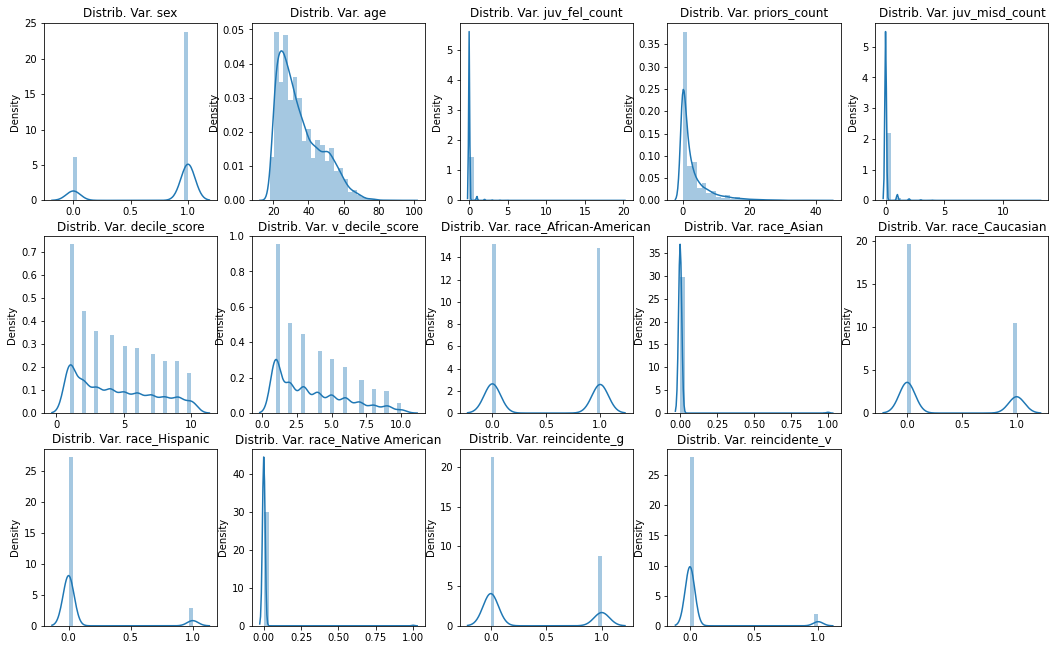

In [ ]:
# Representamos los histogramas de los datos completos
plt.figure(figsize=(18,15))
n = 0
for i, column in enumerate(compas.columns):
    n+=1
    plt.subplot(4, 5, n)
    sns.distplot(compas[column], bins=30)
    plt.title('Distrib. Var. {}'.format(column))
    plt.xlabel('')
plt.show()

Observaciones:
* Más presos hombres que mujeres en el estudio.
* Variable "age" muy escorada hacia la izquierda (20 años). Lo mismo sucede con "decile_score" y "v_decile_score" (más frecuente puntuaciones más bajas de la evaluación Compas).
* Variables sobre el historial de los presos "juv_fel_count", "juv_misd_count" y "priors_count" se concentran en torno al cero, lo que indica que la mayor parte de los presos no tenían historial delictivo previo.


### 6.4. Relación de las variables X con las targets Y

#### 6.4.1. Reincidencia general

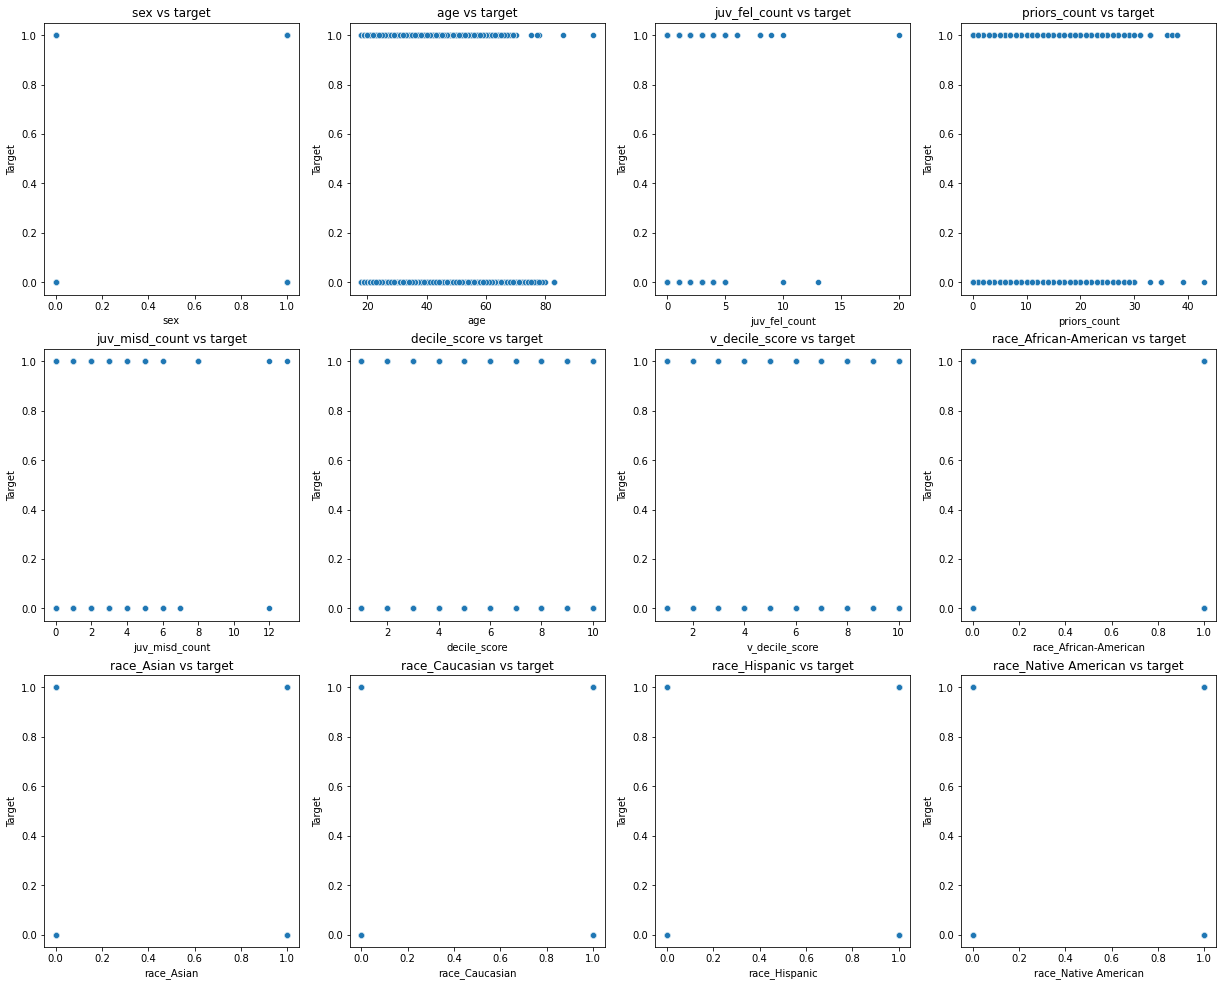

In [ ]:
# Relaciones en el caso de reincidencia por delitos de tipo general
relaciones_vs_target(X_g,Y_g)


Observaciones:
* Posible mayor acumulación de reincidentes a edades menores.
* Posible mayor acumulación de reincidentes con delitos de joven.

#### 6.4.2. Reincidencia violenta

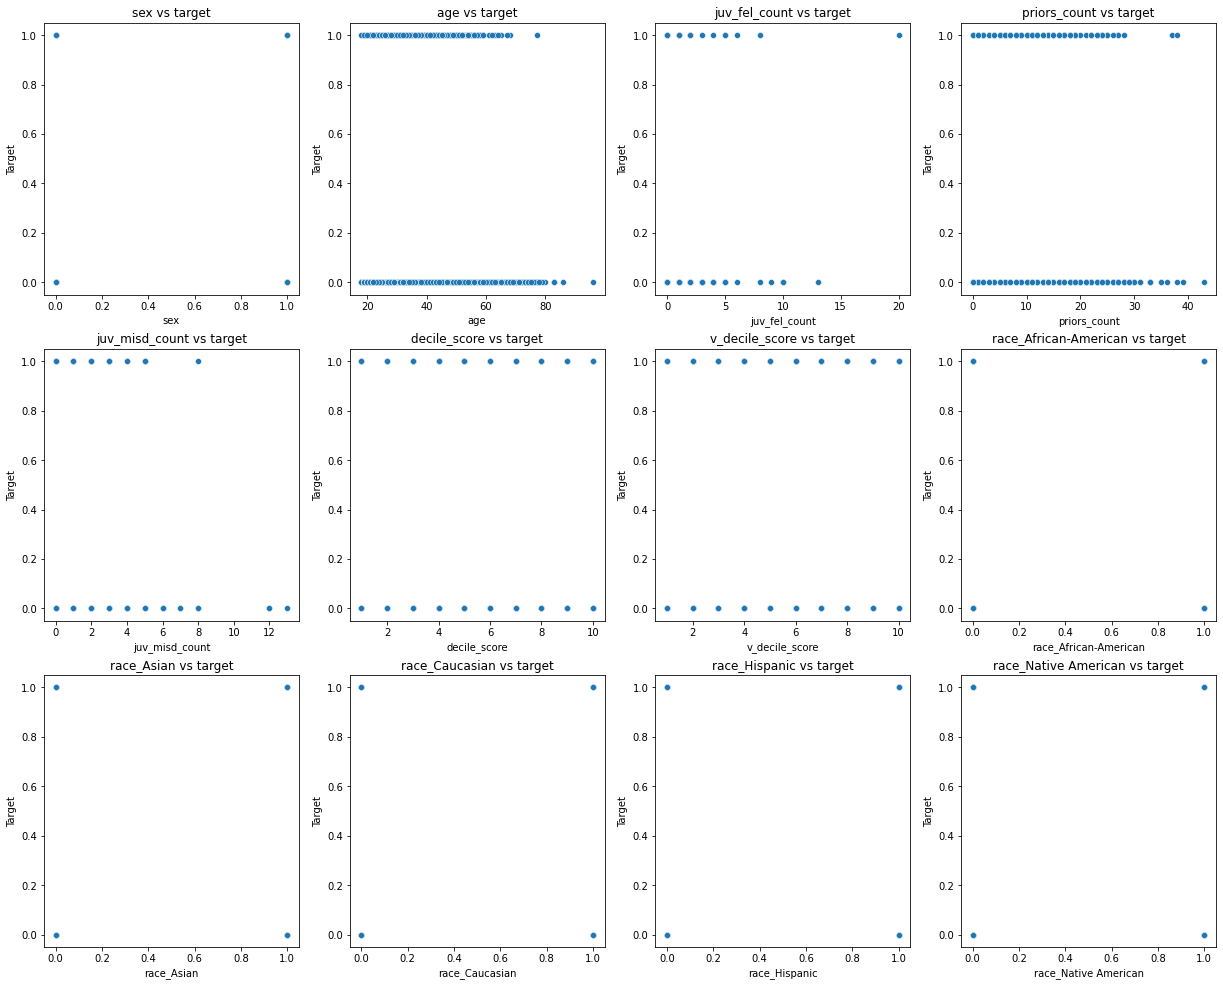

In [ ]:
# Relaciones en el caso de reincidencia por delitos de tipo violento
relaciones_vs_target(X_v,Y_v)

Posible mayor acumulación de reincidentes por delitos con violencia en jóvenes

### 6.5. Histogramas positivos-negativos

#### 6.5.1. Reincidencia general

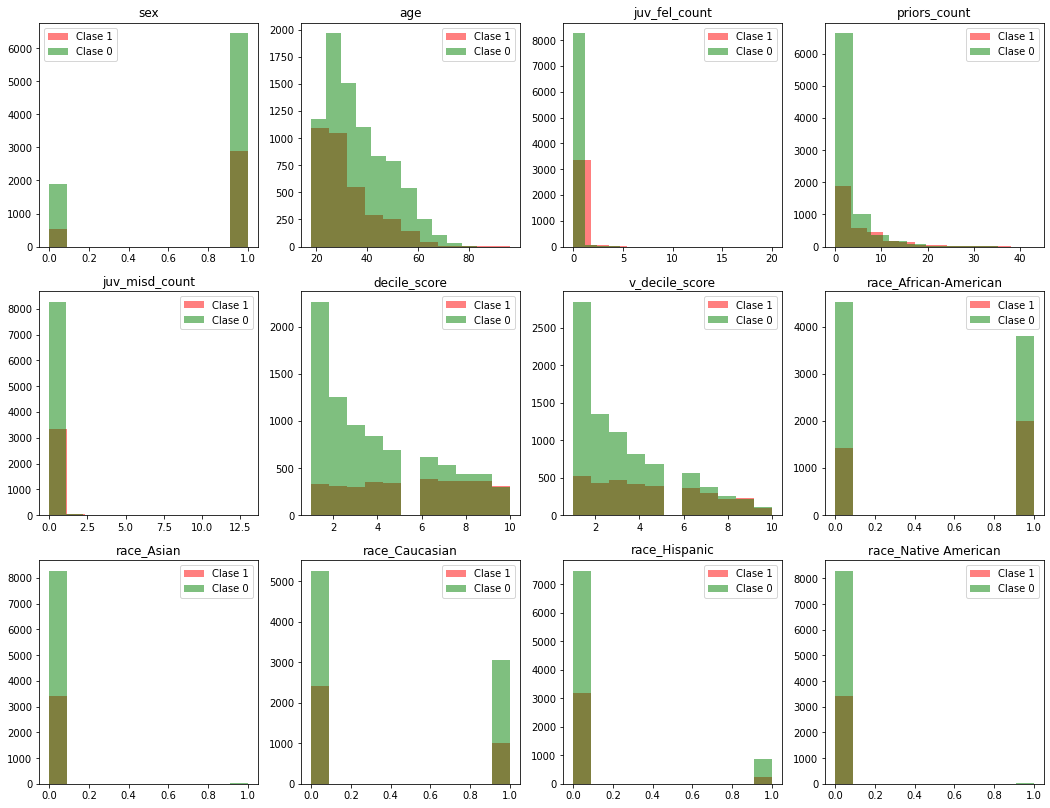

In [ ]:
# Histogramas separando las features por el valor de la target
hist_pos_neg_feat(X_g,Y_g)

Observaciones:
* Más reincidentes a edades menores.
* Reparto homogéneo de la reincidencia en todas las puntuaciones del modelo Compas.
* Mayor tendencia a la reincidencia en afroamericanos.

#### 6.5.1. Reincidencia violenta

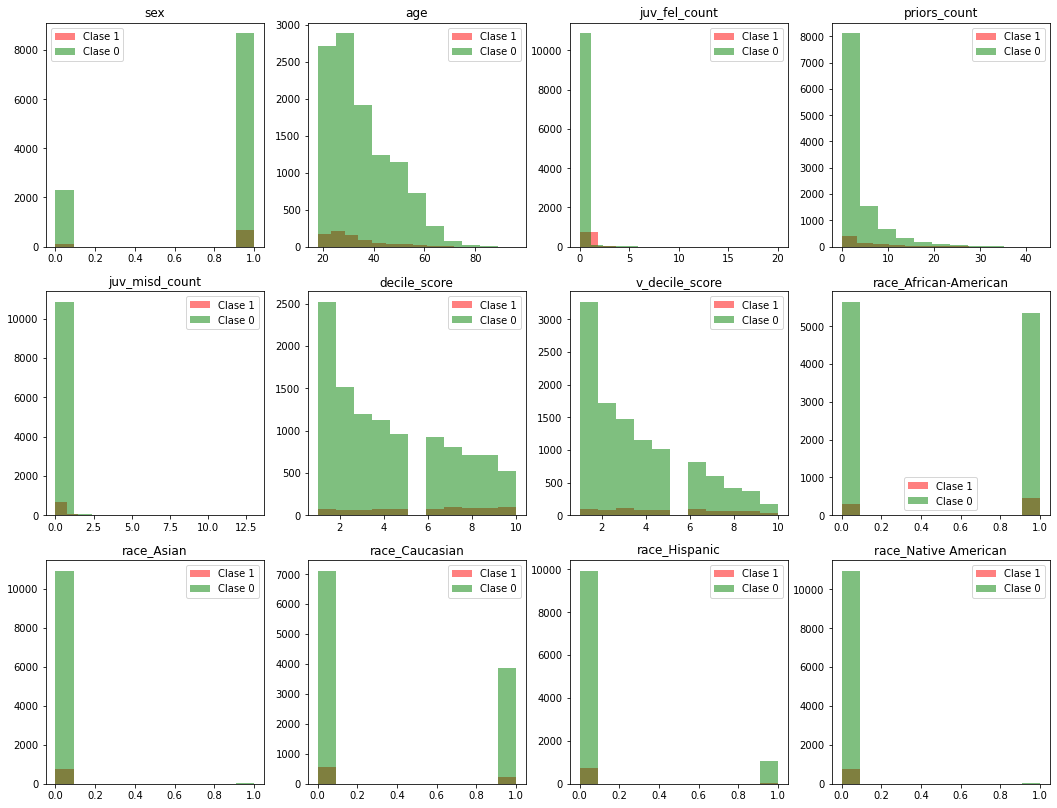

In [ ]:
hist_pos_neg_feat(X_v,Y_v)

* Más reincidentes a edades menores.
* Reparto homogéneo de la reincidencia en todas las puntuaciones del modelo Compas.

### 6.6. Matriz de correlación

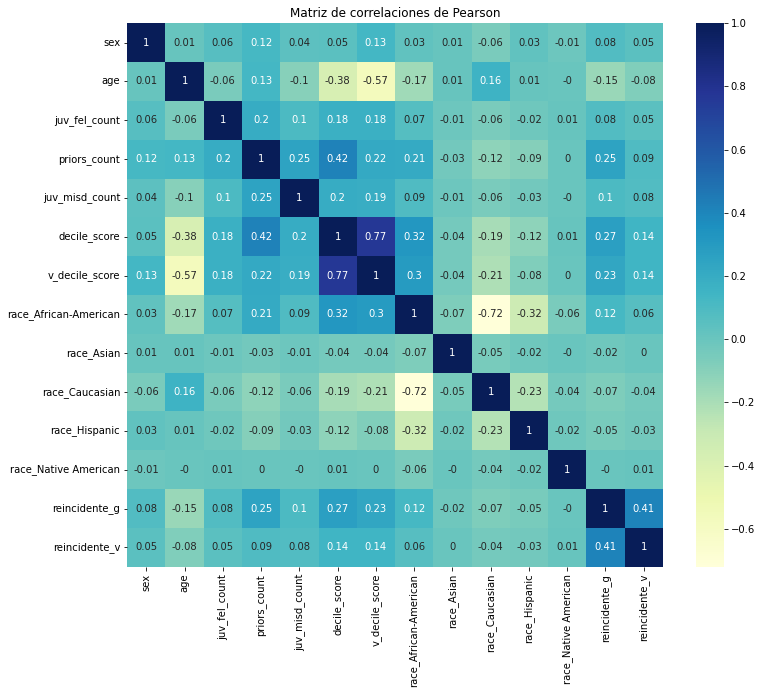

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(round(compas.corr(method='pearson'),2),cmap="YlGnBu",annot=True)
plt.title ('Matriz de correlaciones de Pearson')
plt.show()

Observaciones:
* Correlación positiva fuerte (>0.5) entre "decile_score" y "v_decile_score". Parece lógico pensar que las puntuaciones de riesgo de reincidencia del método Compas para ambos tipos de reincidencia, con y sin violencia, estén correlacionadas.
* Correlación negativa fuerte entre "race_Caucasian" y "race_Afro-American". Son las clases mayoritaras y si el preso no pertenece a una pertenece a la otra.
* Correlación negativa fuerte entre "age" y "v_decile_score". Parece que obtienen puntuaciones más altas de riesgo de rencidencia violenta los más jóvenes.
* Las mayores correlaciones con las targets son:
    * Para "reincidente_g": "decile_score", "priors_count", "v_decile_score", "age".
    * Para "reincidente_v": "decile_score", "v_decile_score".
* No observamos valores suficientemente altos como para generar problemas de multicolinealidad en los modelos a aplicar (>0.9).

### 6.7. Evaluación problema clases desbalanceadas

Este problema se produce cuando la target tiene muchos más valores de una clase que de otra en los datos con los que vamos a entrenar al modelo. Esto afecta negativamente a su capacidad predictiva para nuevos casos de la clase con menos.

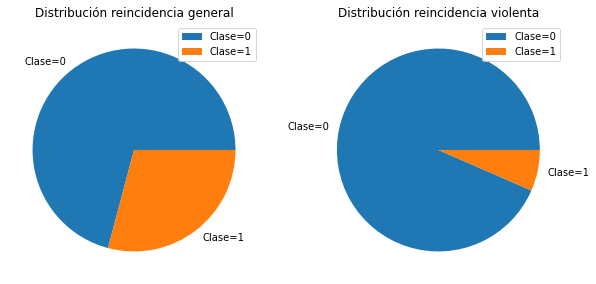

In [ ]:
#Representamos el volumen de observaciones de ambas clases de la target (0: no reincidente, 1:reincidente)
plt.figure(figsize=(10,5))

# Reincidencia general
plt.subplot(121)
plt.pie(compas.reincidente_g.value_counts(),labels=['Clase=0','Clase=1'])
plt.legend()
plt.title('Distribución reincidencia general')

# Reincidencia con violencia
plt.subplot(122)
plt.pie(compas.reincidente_v.value_counts(),labels=['Clase=0','Clase=1'])
plt.legend()
plt.title('Distribución reincidencia violenta')

plt.show()

In [ ]:
compas.reincidente_v.value_counts(normalize=True)

0    0.934592
1    0.065408
Name: reincidente_v, dtype: float64

In [ ]:
0.934592/0.065408

14.288649706457926

Observamos que tenemos un problema de clases desbalanceadas, con pocos reincidentes, fundamentalmente en la distribución de la reincidencia con violencia. 

Por este motivo, a la hora de escoger un algoritmo de machine learning, nos vamos a decantar por el **xgboost**. Es un algoritmo muy eficiente en problemas de clases desbalanceadas. Esto se debe a que el boosting tiene más en cuenta los errores, por lo que es una manera de tratar las clases menos repetidas.  Usa modelos simples de árboles de decisión en secuencia, creándose cada árbol de forma que corrija los errores del anterior.  Mejora el rendimiento general haciendo que un modelo simple posterior les dé más importancia a los errores cometidos por un modelo simple previo y las predicciones de cada modelo simple se combinan por medio de una votación para producir la predicción final. Los algoritmos no se entrenan independientemente, sino que se ponderan según los errores de los anteriores. Se trata de un método que reduce el sesgo. Admás no es sensible a atípicos.

Tampoco vamos a requerir estandarizar los datos al ser un modelo basado en árboles de decisión.

Como desventaja tiene que nuevamente es un modelo "caja negra" y no ofrece interpretabilidad.

## 7. División de los datos en train y test
Vamos a dividir los datos en dos conjuntos: uno para entrenar al modelo (train) y otro para valorar su capacidad predictiva
(test).

Hacemos 2 tipos:
* Predicción de la reincidencia general.
* Predicción de la reincidencia violenta.

In [ ]:
# Dividimos los datos en train y test, con un 20% de tamaño de test
X_g_train,X_g_test,Y_g_train,Y_g_test=train_test_split(X_g,Y_g,test_size=0.2,random_state=0)
X_v_train,X_v_test,Y_v_train,Y_v_test=train_test_split(X_v,Y_v,test_size=0.2,random_state=0)

## 8. Aplicación de un modelo Xgboost

Vamos a intentar mejorar los resultados del modelo Compas, que ya evaluamos en un notebook anterior. Se observó una AUC_ROC para la predicción de reincidencia general de 0.60 y para la reincidencia violenta 0.58.
(Vease https://www.kaggle.com/code/rubengiljimenez/compas-analisis)

### 8.1. Reincidencia general

In [ ]:
# Creación del modelo por defecto
modelo_g=XGBClassifier()

# Entrenamiento del modelo
modelo_g.fit(X_g_train,Y_g_train)

# Predicciones del conjunto de test
Y_g_test_pred=modelo_g.predict(X_g_test)

[11:53:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Modelo reincidencia general:

              precision    recall  f1-score   support

           0       0.75      0.88      0.81      1654
           1       0.51      0.29      0.37       698

    accuracy                           0.71      2352
   macro avg       0.63      0.59      0.59      2352
weighted avg       0.68      0.71      0.68      2352

AUC_ROC:  0.59


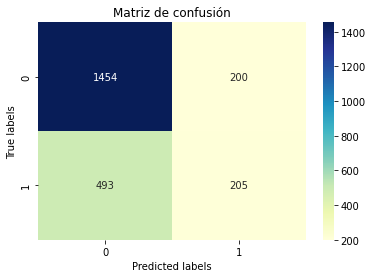

In [ ]:
print('Modelo reincidencia general:\n')

print(classification_report(Y_g_test,Y_g_test_pred,digits=2))
print('AUC_ROC: ',round(roc_auc_score(Y_g_test,Y_g_test_pred),2))
matriz_confusion(Y_g_test,Y_g_test_pred)

Vemos que el modelo no tiene una buena capacidad predictiva, sobre todo para la clase 1 (reincidentes). Vamos a intentar tunear los hiperparámetros del modelo para mejorar los resultados.

Los principales **parámetros** a definir de este algortimo:
* **max_depth**: es el número máximo de nodos permitidos desde la raíz hasta la hoja más lejana de un árbol. Los árboles más profundos pueden modelar relaciones más complejas al agregar más nodos, pero a medida que profundizamos, las divisiones se vuelven menos relevantes y, a veces, solo se deben al ruido, lo que hace que el modelo se sobreajuste.
* **gamma**: es el peso mínimo (o número de muestras si todas las muestras tienen un peso de 1) requerido para crear un nuevo nodo en el árbol. Un valor más pequeño permite que el algoritmo cree hijos que correspondan a menos muestras, lo que permite árboles más complejos, pero nuevamente, más propensos a sobreajustarse.
* **eta**: controla la tase de aprendizaje. Corresponde a la "contracción" de los pesos asociados a las características después de cada ronda, en otras palabras, define la cantidad de "corrección" que hacemos en cada paso. En la práctica, tener un nivel más bajo hace que nuestro modelo sea más robusto al sobreajuste, por lo que, por lo general, cuanto menor sea la tasa de aprendizaje, mejor. Pero con una más baja, necesitamos más rondas de impulso, lo que lleva más tiempo entrenar, a veces solo para mejoras marginales.
* **subsample**: corresponde a la fracción de observaciones (las filas) a submuestrear en cada paso. De forma predeterminada, se establece en 1, lo que significa que usamos todas las filas.
* **colsample_bytree**: corresponde a la fracción de entidades (las columnas) a utilizar. Por defecto se establece en 1 lo que significa que usaremos todas las columnas.

In [ ]:
# Combinación de parámetros del modelo por defecto
modelo_g.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)>

### Optimización de parámetros mediante validación cruzada

In [ ]:
clf=XGBClassifier(use_label_encoder=False)

# Diccionario de parámetros
params={'max_depth':[3,4],
        'n_estimators':[50,100],
        'eta':[0.01,0.02],
        'gamma':[0,0.01],
        'scale_pos_weight': [2],# ratio entre numero de valores de la clase negativa frente a la positiva 
        'eval_metric':['error'],
        'verbosity':[1]} 

# Validación cruzada
modelo_g_gs=GridSearchCV(clf,params,cv=10,scoring='balanced_accuracy',n_jobs=-1,verbose=True)

# Entrenamiento del modelo
modelo_g_gs.fit(X_g_train,Y_g_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     use_label_encoder=False,
  

In [ ]:
# Mejores paramétros obtenidos por validación cruzada
modelo_g_gs.best_params_

{'eta': 0.02,
 'eval_metric': 'error',
 'gamma': 0,
 'max_depth': 3,
 'n_estimators': 100,
 'scale_pos_weight': 2,
 'verbosity': 1}

In [ ]:
# Obtenemos las predicciones
Y_g_test_pred=modelo_g_gs.predict(X_g_test)

Modelo reincidencia general:

              precision    recall  f1-score   support

           0       0.81      0.73      0.77      1654
           1       0.48      0.59      0.53       698

    accuracy                           0.69      2352
   macro avg       0.64      0.66      0.65      2352
weighted avg       0.71      0.69      0.70      2352

AUC_ROC:  0.66


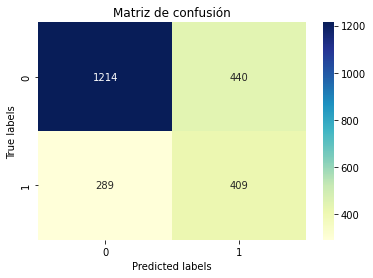

In [ ]:
print('Modelo reincidencia general:\n')

print(classification_report(Y_g_test,Y_g_test_pred,digits=2))
print('AUC_ROC: ',round(roc_auc_score(Y_g_test,Y_g_test_pred),2))
matriz_confusion(Y_g_test,Y_g_test_pred)

Hemos mejorado los resultados del modelo generado por defecto. Hemos tuneado los parámetros para predecir mejor los casos reincidentes, con el handicap de las clases desbalanceadas.

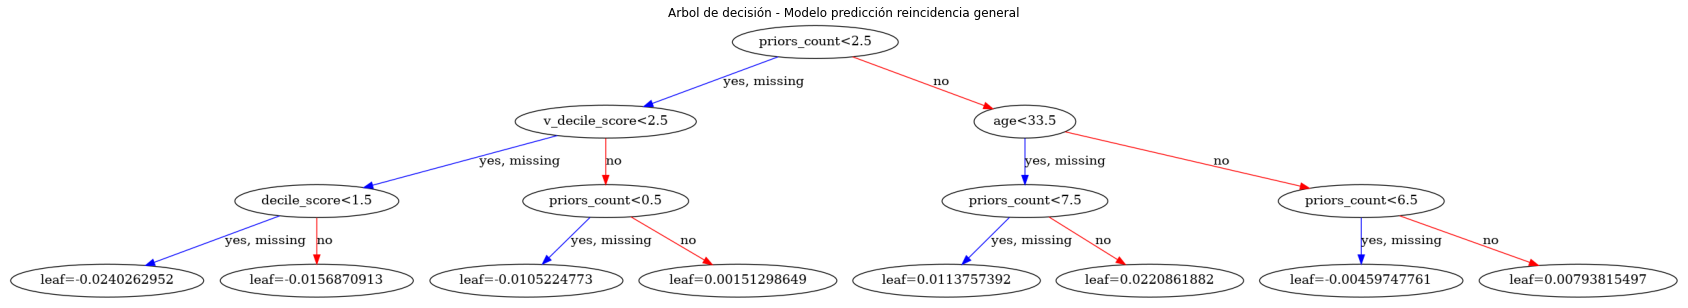

In [ ]:
# Veamos el árbol de decisión obtenido
fig, ax = plt.subplots(figsize=(30, 30))
plt.title('Arbol de decisión - Modelo predicción reincidencia general')
plot_tree(modelo_g_gs.best_estimator_, num_trees=4, ax=ax)
plt.show()

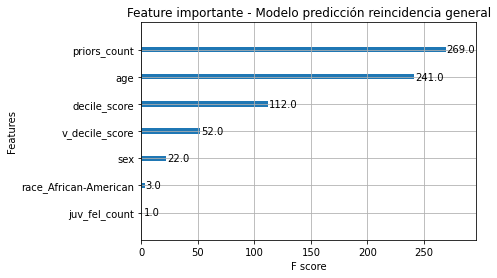

In [ ]:
# Veamos cuales son las features con mayor importancia del modelo predictivo.
plot_importance(modelo_g_gs.best_estimator_,title='Feature importante - Modelo predicción reincidencia general')
plt.show()

### 8.2. Reincidencia violenta

In [ ]:
# Calculamos el ratio del número de valores de la clase 0 entre los de la clase 1
ratio= len(compas[compas.reincidente_v==0])/len(compas[compas.reincidente_v==1])
ratio

14.288686605981795

In [ ]:
clf=XGBClassifier(use_label_encoder=False)

# Diccionario de parámetros
params={'max_depth':[5,10],
        'n_estimators':[10,50],
        'eta':[0.01,0.02],
        'gamma':[0,0.01],
        'scale_pos_weight': [ratio],#aumentamos el paso de la clase 1 con menos casos en la proporción de casos clase 0 entre casos clase 1
        'eval_metric':['error'],
        'verbosity':[1]} 

# Validación cruzada
modelo_v_gs=GridSearchCV(clf,params,cv=10,scoring='balanced_accuracy',n_jobs=-1,verbose=True)

# Entrenamiento del modelo
modelo_v_gs.fit(X_v_train,Y_v_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None...
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     use_label_encoder=False,
                                     validate_parameters=None, verbosity=N

In [ ]:
# Mejores paramétros obtenidos por validación cruzada
modelo_v_gs.best_params_

{'eta': 0.02,
 'eval_metric': 'error',
 'gamma': 0,
 'max_depth': 5,
 'n_estimators': 50,
 'scale_pos_weight': 14.288686605981795,
 'verbosity': 1}

In [ ]:
# Obtenemos las predicciones
Y_v_test_pred=modelo_v_gs.predict(X_v_test)

Modelo reincidencia violenta:

              precision    recall  f1-score   support

           0       0.96      0.66      0.78      2211
           1       0.10      0.60      0.17       141

    accuracy                           0.66      2352
   macro avg       0.53      0.63      0.48      2352
weighted avg       0.91      0.66      0.75      2352

AUC_ROC:  0.63


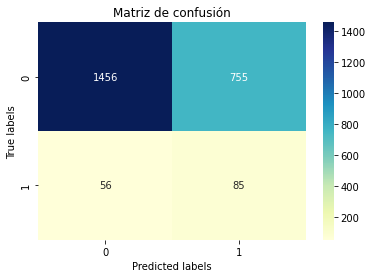

In [ ]:
print('Modelo reincidencia violenta:\n')

print(classification_report(Y_v_test,Y_v_test_pred,digits=2))
print('AUC_ROC: ',round(roc_auc_score(Y_v_test,Y_v_test_pred),2))
matriz_confusion(Y_v_test,Y_v_test_pred)

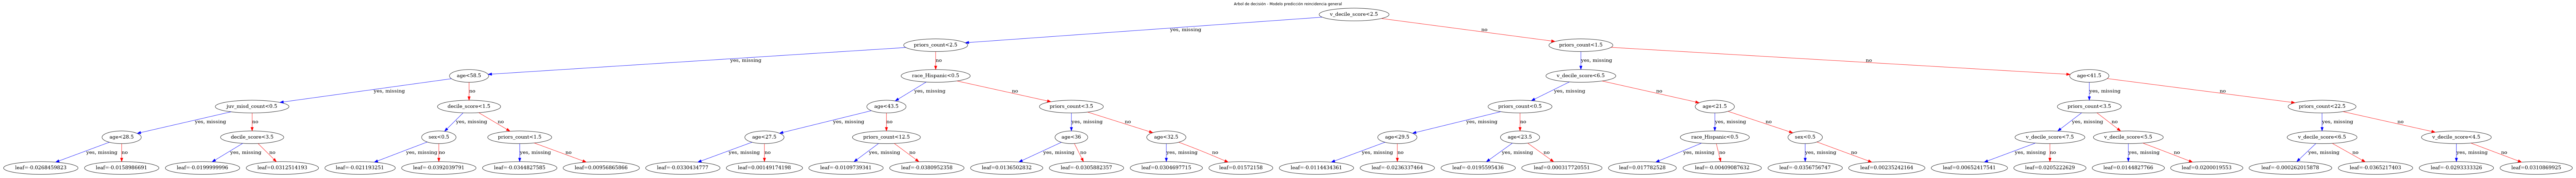

In [ ]:
# Veamos el árbol de decisión obtenido
fig, ax = plt.subplots(figsize=(150,150))
plt.title('Arbol de decisión - Modelo predicción reincidencia general')
plot_tree(modelo_v_gs.best_estimator_, ax=ax,render=True)
plt.show()

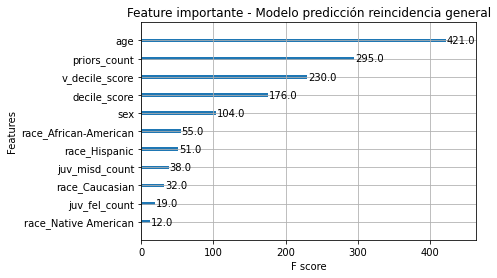

In [ ]:
# Veamos cuales son las features con mayor importancia del modelo predictivo.
plot_importance(modelo_v_gs.best_estimator_,title='Feature importante - Modelo predicción reincidencia general')
plt.show()

### 8.3. Conclusión

Hemos conseguido mejorar la capacidad predictiva de los modelos:
* Reinciencia general: AUC_ROC de 0.60 a 0.66
* Reincidencia violenta: AUC_ROC de 0.58 a 0.63.

En el caso de reincidencia violenta hemos sacrificado la precisión al entrenar el modelo aumentando el peso de la clase minoritaria, empeorando la predicción correcta de casos no reincidentes (clase 0) para predecir correctamente más casos de reincidentes (clase 1).

